# **Homework 4 - Hard coding**

## **1. Implementing your own Shazam**

In [1]:
# Import some useful libraries
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd
import pandas as pd
import random as rd
import math
import time
import sympy

from collections import defaultdict
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import preprocessing
from pandas.api.types import is_string_dtype, is_numeric_dtype
from numpy import linalg
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from pathlib import Path, PurePath   
from tqdm.notebook import tqdm

# Import our functions

In [2]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_peaks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """Plots the spectrogram and peaks 

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure()
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_peaks(audio, offset, duration, hop_size):
    """Load the tracks and peaks of an audio.

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        offset (float): start reading after this time (in seconds)
        duration (float): only load up to this much audio (in seconds)
        hop_size (int): the hop_length

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, offset=offset, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks

In [3]:
N_TRACKS = 1413
HOP_SIZE = 512
OFFSET = 1.0
DURATION = 30 # TODO: to be tuned!
THRESHOLD = 0 # TODO: to be tuned!

In [6]:
data_folder = Path("data/mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

### Preprocessing

In [9]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    convert_mp3_to_wav(str(track))

### Audio signals

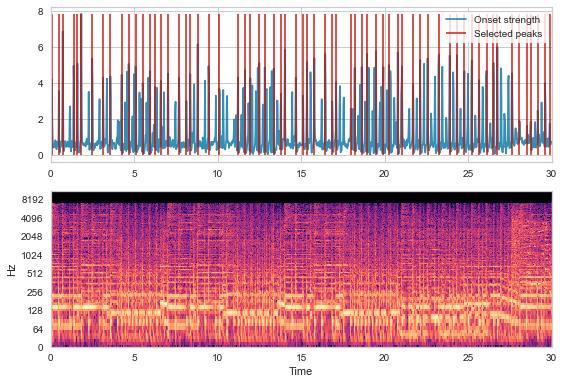

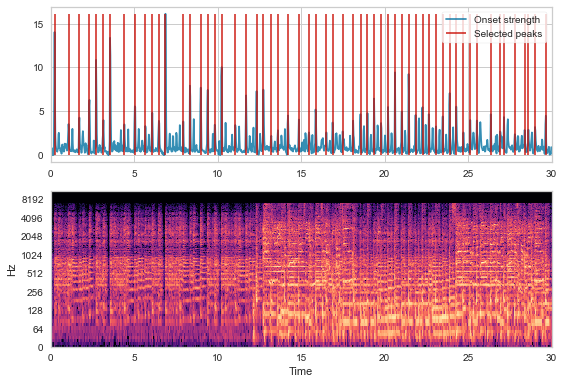

In [5]:
for idx, audio in enumerate(tracks):
    if idx >= 2:
        break
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    plot_spectrogram_and_peaks(track, sr, peaks, onset_env)

In [7]:
song_names = np.array([])
with open('data/mp3s-32k/all.list') as f:
    aux = f.readlines()
    for x in aux:
        song_names = np.append(song_names, x.replace('\n',''))
print(song_names)

['aerosmith/Aerosmith/01-Make_It' 'aerosmith/Aerosmith/02-Somebody'
 'aerosmith/Aerosmith/03-Dream_On' ... 'u2/Zooropa/08-The_First_Time'
 'u2/Zooropa/09-Dirty_Day' 'u2/Zooropa/10-The_Wanderer']


In [8]:
all_peak_songs = []
maxPeak = 0
for idx, audio in tqdm(enumerate(tracks)):
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    if max(peaks) > maxPeak:
        maxPeak = max(peaks)
    all_peak_songs.append(peaks)
    
print("maxPeak: ", maxPeak)

0it [00:00, ?it/s]

maxPeak:  1291


In [28]:
def peaks_sparse(peaks):
    ret = []
    for peaks in tqdm(peaks):
        peak_sparse = np.zeros(maxPeak+1)
        for y in peaks:
            peak_sparse[y] = 1
        ret.append(peak_sparse)
    return ret


In [29]:

all_peak_sparse = peaks_sparse(all_peak_songs)


  0%|          | 0/1413 [00:00<?, ?it/s]

In [30]:
def get_signatures(n_perm, peaks_sparse):
    signatures = []

    for peaks in tqdm(peaks_sparse):
        np.random.seed(1) #we start always with the same seed to get the same sequence of permutations
        signature = np.array([])
        for x in range(n_perm):
            np.random.shuffle(peaks)
            signature = np.append(signature, np.where(peaks == 1)[0][0])
        signatures.append(signature)
    return signatures

In [31]:

n_perm = 100
signatures = get_signatures(n_perm, all_peak_sparse)
#signatures

  0%|          | 0/1413 [00:00<?, ?it/s]

In [32]:
#h(x) = (x*a + b) mod m
def hash_function(x,a,b,m):
    return sum((x*a + b)) % m

In [33]:
b = 4 # setting b parameter, we will divide signature_i in groups of len(signature_i)/b rows and hash it separately

m = sympy.nextprime(maxPeak)

buckets = [dict() for number in range(m+1)] #each position is one bucket, inside we store a dict where the key is the title of the song, and the value the signature

count = 0

for sig in signatures:
    
    aux = len(sig / b)
    s = sig
    for x in range(b):
        if x == b-1: #last
            actSig = s
        else:
            actSig = s[:aux]
            s = s[aux:]
        bucket_num = hash_function(sig, np.random.randint(0, 10000), np.random.randint(0, 10000), m)
        buckets[int(bucket_num)][song_names[count]] = sig
    count += 1
    
    



### Query

In [61]:
query_songs =  Path("./data/query/").glob("*.wav")
all_peak_query_songs = []
query_songs_name = []
for idx, audio in tqdm(enumerate(query_songs)):
    query_songs_name.append(str(audio))
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    all_peak_query_songs.append(peaks)

0it [00:00, ?it/s]

all_peak_query_songs:  [array([   7,   24,   40,   57,   73,   89,  107,  124,  140,  156,  172,
        190,  206,  222,  238,  255,  272,  288,  304,  321,  337,  353,
        369,  387,  402,  419,  435,  503,  520,  536,  553,  569,  586,
        602,  619,  636,  653,  669,  686,  702,  719,  734,  750,  766,
        784,  800,  817,  833,  850,  866,  883,  899,  916,  931,  948,
        964,  981,  998, 1013, 1029, 1047, 1063, 1080, 1096, 1112, 1129,
       1146, 1162, 1180, 1196, 1211, 1228, 1245, 1261, 1277], dtype=int64), array([   9,   28,   41,   54,   67,   87,  107,  119,  167,  187,  200,
        221,  241,  255,  268,  280,  308,  328,  348,  360,  380,  399,
        426,  439,  466,  486,  505,  519,  545,  559,  584,  597,  624,
        637,  664,  678,  705,  717,  745,  766,  785,  798,  819,  839,
        865,  879,  905,  927,  946,  959,  986,  999, 1025, 1046, 1065,
       1086, 1106, 1119, 1146, 1159, 1186, 1200, 1227, 1240, 1267, 1280],
      dtype=int64), arr

In [36]:
all_peak_query_sparse = peaks_sparse(all_peak_query_songs)

  0%|          | 0/10 [00:00<?, ?it/s]

In [39]:
signatures_query = get_signatures(n_perm, all_peak_query_sparse)

  0%|          | 0/10 [00:00<?, ?it/s]

[array([ 11.,  14.,  12.,  25.,  37.,  34.,   9.,  15.,   5.,  41.,  10.,
         11.,  18.,   5.,  28.,  13.,  10.,  24.,   2.,  13.,  16.,  32.,
         31.,  17.,   1.,   6.,   1.,   3.,   3.,  40.,  38.,   7.,   6.,
          9.,   8.,  11.,  26.,   0.,   3.,  17.,  18.,  10.,   9.,  11.,
          1.,  63.,  27.,  16.,   1.,  14.,  11.,  11.,  49.,   3.,  10.,
        122.,  32.,   0.,   1.,   9.,  21.,   4.,  11.,   5.,  12.,   2.,
          7.,   3.,  37.,  60.,   7., 108.,   5.,  15.,  12.,  27.,  16.,
         28.,  50.,   9.,   0.,   3.,   9.,  19.,   5.,   3.,   3.,   7.,
          6.,   1.,  21.,   2.,   8.,   7.,  18.,  37.,  28.,  41.,  58.,
          4.]),
 array([11.,  7., 51., 10.,  1.,  8., 15.,  6.,  8., 13.,  0., 32.,  9.,
        17.,  2.,  8., 43., 11., 23., 31., 19., 10., 13.,  8.,  8., 17.,
         4., 48., 21.,  8., 37., 30.,  7., 18., 18., 12., 18., 82., 11.,
        24., 19.,  7., 31., 23., 13., 70.,  8.,  9., 17., 19.,  6., 22.,
        24., 10., 64.,  7.

In [46]:
def jaccard_similarity(sig1, sig2):
    return len(np.intersect1d(sig1, sig2)) / len(np.union1d(sig1, sig2)) 
    

In [64]:
count = 0
for sig in signatures_query:
    candidate_songs = {} #here we store all the candidate songs for a query song. When we compute the hash of each one of the bands and we know the bucket, we take all the songs on it as candidates.
    
    aux = len(sig / b)
    s = sig
    for x in range(b):
        if x == b-1: #last
            actSig = s
        else:
            actSig = s[:aux]
            s = s[aux:]
        bucket_num = hash_function(sig, np.random.randint(0, 10000), np.random.randint(0, 10000), m)
        #print("bucket_num: ", bucket_num)
        candidate_songs.update(buckets[int(bucket_num)])
    #print("final state of candidate_songs: ", candidate_songs)
    
    best_match = 'No match'
    best_match_jaccard_score = 0
    
    for x in candidate_songs.keys():
        punct = jaccard_similarity(candidate_songs[x], sig)
        if punct > best_match_jaccard_score:
            best_match_jaccard_score = punct
            best_match = x
            
    print("BEST MATCH for song " + query_songs_name[count] + " is...\n" + best_match + "  with a Jaccard similarity score of " + str(best_match_jaccard_score) + "\n\n")
    count += 1



BEST MATCH for song data\query\track1.wav is...
roxette/Room_Service/10-Fool  with a Jaccard similarity score of 0.6


BEST MATCH for song data\query\track10.wav is...
dave_matthews_band/Stand_Up/08-Out_Of_My_Hands  with a Jaccard similarity score of 0.5576923076923077


BEST MATCH for song data\query\track2.wav is...
fleetwood_mac/Tusk/15-I_Know_I_m_Not_Wrong  with a Jaccard similarity score of 0.7045454545454546


BEST MATCH for song data\query\track3.wav is...
cure/The_Head_on_the_Door/04-Six_Different_Ways  with a Jaccard similarity score of 0.5384615384615384


BEST MATCH for song data\query\track4.wav is...
garth_brooks/Garth_Brooks_The_Limited_Series_/04-Uptown_Down-Home_Good_Ol_Boy  with a Jaccard similarity score of 0.6530612244897959


BEST MATCH for song data\query\track5.wav is...
steely_dan/Aja/01-Black_Cow  with a Jaccard similarity score of 0.6071428571428571


BEST MATCH for song data\query\track6.wav is...
radiohead/Pablo_Honey/11-Lurgee  with a Jaccard similarity scor

## **2. Grouping songs together!**

*We play with a dataset gathering songs from the International Society for Music Information Retrieval Conference. The tracks (songs) include much information. We focus on the track information, features (extracted with librosa library from Python) and audio variables provided by Echonest (now Spotify).*

### **2.1 Getting your data!**

In [24]:
# We use this function to clean our dataset, in particular to fill the NaN values.
def fill_nan(df):
    for i in df.columns:
        if df[i].isnull().any() == True:
            # Check for columns with NaN values
            if is_numeric_dtype(df[i]) == True:
                # If is a numeric column fillna with the mean of the column
                df[i] = df[i].fillna(df[i].mean())
            elif is_string_dtype(df[i]) == True:
                # If is a string column fill na with an empty string
                df[i] = df[i].fillna("")
    
    print('All NaN filled!')         

We upload, using *pandas*, three different csv dataset: *tracks.csv*, *features.csv* and *echonest.csv*.

In [25]:
tracks = pd.read_csv("tracks.csv")
echonest = pd.read_csv("echonest.csv")
features = pd.read_csv("features.csv")

We can get a look at these three different datasets. Let's start with *tracks*.

In [26]:
print(tracks.shape)
tracks.head()

(106574, 53)


,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,...,NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


With our function *'fill_nan'* we preprocess our dataset filling NaN values.

In [27]:
fill_nan(tracks)

All NaN filled!


In [28]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   track_id                  106574 non-null  int64  
 1   album_comments            106574 non-null  int64  
 2   album_date_created        106574 non-null  object 
 3   album_date_released       106574 non-null  object 
 4   album_engineer            106574 non-null  object 
 5   album_favorites           106574 non-null  int64  
 6   album_id                  106574 non-null  int64  
 7   album_information         106574 non-null  object 
 8   album_listens             106574 non-null  int64  
 9   album_producer            106574 non-null  object 
 10  album_tags                106574 non-null  object 
 11  album_title               106574 non-null  object 
 12  album_tracks              106574 non-null  int64  
 13  album_type                106574 non-null  o

*Tracks* has 106,573 observations over 53 features. Most of the features regards information and descriptions about the track, the album and the artist. There are both numerical (18) and string-type (35) variables.

Now, we can look at *features*.

In [29]:
print(features.shape)
features.head()

(106574, 519)


,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
1,3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
2,5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
3,10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
4,20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


In [30]:
fill_nan(features)

All NaN filled!


In [31]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106574 entries, 0 to 106573
Columns: 519 entries, track_id to zcr_std_01
dtypes: float64(518), int64(1)
memory usage: 422.0 MB


*Features* has 106,574 observations over 519 features. There are only numeric variables regarding some measures about the tracks.

Finally, we look at *echonest*.

In [32]:
print(echonest.shape)
echonest.head()

(13129, 250)


,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,NaN,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,2008-03-11,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,NaN,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705


In [33]:
fill_nan(echonest)

All NaN filled!


In [34]:
echonest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13129 entries, 0 to 13128
Columns: 250 entries, track_id to temporal_features_223
dtypes: float64(244), int64(1), object(5)
memory usage: 25.0+ MB


*Echonest* has 13129 observations over 250 features. These are features extracted by Spotify about some particular characteristics of the tracks. There are 245 numerical and 5 string variables.

### **2.2 Choose your features (variables)!**

We decided to perform **PCA** on these three datasets in order to reduce their dimensionality. Before applying the PCA, we need to do two important things:

1. Remove all the 'object' dtypes variable from the datasets because they can't be fitted into the PCA.

In [35]:
# We want to consider only non-object types of variable to perform PCA.
def remove_object_dtype(df):
    new_df = df.select_dtypes(exclude = 'object') 
    return new_df

2. Standardize our values to eliminate problems derived by different scales and unity measures.


In [36]:
# We leverage the StandardScaler module from sklearn.preprocessing
def scale_f(df):
    scaler = preprocessing.StandardScaler()
    # We don't want to consider 'track_id' - the first col - because we need it for the merge
    new_df = pd.DataFrame(scaler.fit_transform(df[df.columns[1:]].values), columns = df.columns[1:])
    # Add track_id
    final_df = pd.concat([df[df.columns[:1]], new_df], axis = 1)
    
    return final_df

Let's start working with the *echonest* dataframe.

In [37]:
# Remove object dtype variables
echonest_r = remove_object_dtype(echonest)

# Standardize the remaining values 
echonest_s = scale_f(echonest_r)

# Give a look at our ready-to-analyze dataset
echonest_s.head()

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_artist_latitude,...,temporal_features_214,temporal_features_215,temporal_features_216,temporal_features_217,temporal_features_218,temporal_features_219,temporal_features_220,temporal_features_221,temporal_features_222,temporal_features_223
0,2,-0.281499,0.991915,0.348732,-1.742887,-0.064267,0.437749,1.223573,0.495983,-0.542858,...,-0.015394,-0.196498,-0.541629,-0.746474,-0.039156,-0.406800,-0.101961,-0.101075,0.886203,0.549691
1,3,-0.391656,0.217484,1.006860,-1.767172,-0.518358,2.639805,0.110726,-0.617788,-0.542858,...,0.224575,-0.092590,-0.360448,-0.411759,-0.023682,-0.402225,0.382370,0.383292,1.407079,0.827430
2,5,-1.253885,1.358338,0.589683,-1.770366,1.172705,0.185049,-0.651745,0.659017,-0.542858,...,-0.188685,0.038956,-0.372166,-0.209735,-0.029780,-0.767287,0.350908,0.352630,1.304715,0.965630
3,10,1.112791,0.898745,1.391929,0.898939,-0.457654,-0.481812,-0.328958,1.897809,-0.000715,...,-0.993299,0.536708,-0.182877,0.139612,-0.010956,1.124812,0.851688,0.849294,2.127603,1.527072
4,134,-0.188870,0.136465,0.082343,-1.718498,-0.577286,3.103507,-0.251046,1.645950,-0.542858,...,0.300454,-0.418382,-0.530095,-0.666811,-0.004175,-0.377522,1.426057,1.427025,2.924718,2.714005


Now, we can proceed with the PCA.

In [38]:
# We set 80 principal components.
pca1 = PCA(n_components=80)

# We don't want to perform it on the track_id column
echonest_red = pca1.fit_transform(echonest_s[echonest_s.columns[1:]])

# Show the total explained variance ratio
print(sum(pca1.explained_variance_ratio_))

0.8974908272065796


If we set 80 as number of principal components we get ~90% of explained total variance. That is our target, because at the end we want to preserve almost the 70% of the total variance of the merged dataset. Let's see in particular, how much variance is explained by every single component.

[0.11091527 0.08435649]


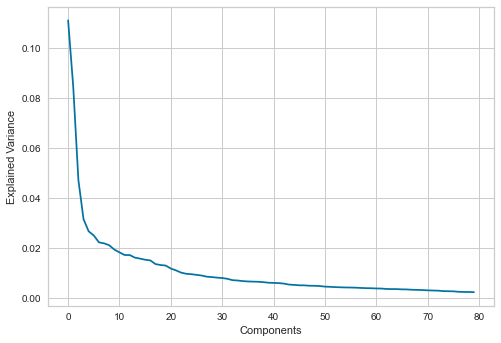

In [39]:
# Show the explained variance of the first two components
print(pca1.explained_variance_ratio_[:2])

# Plot the explained variance of the single principal components.
plt.plot(pca1.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

Obviously the first components have higher values, in particular the first component explains the 11% of the variance and the second one the 8.4%. Now, we create our reducted dataframe with only 81 columns, against the starting 245 ones.

In [40]:
echonest_ = pd.DataFrame(echonest_red, columns = ['Comp_echo_%i' % i for i in range(80)])

# Re-add the track_id column 
echonest_pca = pd.concat([echonest['track_id'], echonest_], axis = 1)

echonest_pca.head()

,track_id,Comp_echo_0,Comp_echo_1,Comp_echo_2,Comp_echo_3,Comp_echo_4,Comp_echo_5,Comp_echo_6,Comp_echo_7,Comp_echo_8,...,Comp_echo_70,Comp_echo_71,Comp_echo_72,Comp_echo_73,Comp_echo_74,Comp_echo_75,Comp_echo_76,Comp_echo_77,Comp_echo_78,Comp_echo_79
0,2,0.779179,-1.709530,0.070460,0.467942,-1.452853,1.097030,-1.332340,0.347361,-0.606074,...,0.182307,-0.529760,-0.013221,0.422226,-0.579445,-0.263976,0.410660,-1.264473,-0.266163,-0.273669
1,3,2.659287,-4.168144,2.407969,-0.459535,0.069061,0.061437,1.349458,1.108543,-1.363354,...,-0.473189,-0.882110,0.624207,0.400812,0.436491,-0.040015,-0.178589,-1.162560,-1.563780,0.907722
2,5,1.375855,-4.540358,2.340129,-0.065438,-0.875892,0.718823,1.769996,0.271911,0.766609,...,0.145065,-0.505266,0.225907,-0.332301,0.420514,-0.805920,-0.163618,-0.667805,-1.219136,-0.815777
3,10,6.612744,-1.134203,0.394953,1.016510,1.060611,0.308338,-2.942857,0.637777,2.171908,...,-2.005337,1.527613,0.035180,0.933184,0.721974,-0.405923,-0.835324,0.518746,-0.490917,-0.006739
4,134,-2.917268,-5.523875,2.751439,-0.619121,0.590171,0.819162,0.538913,-0.309002,-0.320409,...,-0.217544,-0.435121,-0.085403,-0.660261,-0.699552,0.886126,0.573755,-0.721299,0.204571,0.723115


Now we can repeat the same process for the *features* dataframe.

In [41]:
# Remove object dtype variables
features_r = remove_object_dtype(features)

# Standardize the remaining values 
features_s = scale_f(features_r)

# Give a look at our ready-to-analyze dataset
features_s.head()

,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,0.208784,0.452353,-0.008553,0.056482,0.079044,0.017718,0.071164,0.152168,0.090291,...,-1.200560,-1.537657,-1.595043,-0.266432,0.425841,1.007362,0.874131,-0.454603,-0.369213,0.775698
1,3,0.044880,0.050426,0.001063,0.106160,0.090461,-0.020371,0.064405,0.046439,-0.012742,...,-0.938948,-1.210805,-0.675913,-0.299409,0.463112,0.975158,0.643107,-0.454603,-0.491744,1.064853
2,5,0.002712,-0.024945,-0.061548,0.021789,0.109332,0.046419,-0.070494,-0.081502,0.063099,...,-1.561604,-1.461126,-1.162622,-0.254636,-0.034719,0.011006,-0.065367,-0.454603,-0.335249,0.167182
3,10,0.101044,-0.044147,0.186567,-0.026460,0.071382,0.056075,0.088195,0.081984,0.043355,...,-0.655213,-0.595296,-1.299392,-0.090255,0.385908,0.758699,0.889532,-0.454603,0.107731,0.018234
4,20,-0.019632,-0.035814,-0.013339,-0.000614,0.031972,-0.018958,-0.033153,-0.074345,-0.021467,...,-0.098756,0.151932,-0.085646,-0.143811,0.481748,-0.169453,-0.111572,-0.265064,-0.008018,-0.341557


In [42]:
# We set 150 principal components.
pca2 = PCA(n_components=150)

# We don't want to perform it on the track_id column
features_red = pca2.fit_transform(features_s[features_s.columns[1:]])

# Show the total explained variance ratio
print(sum(pca2.explained_variance_ratio_))


0.8983606603100365


If we set 150 as number of principal components we get ~90% of explained total variance. That is our target, because at the end we want to preserve almost the 70% of the total variance of the merged dataset. Let's see in particular, how much variance is explained by every single component.

[0.11981209 0.06802443]


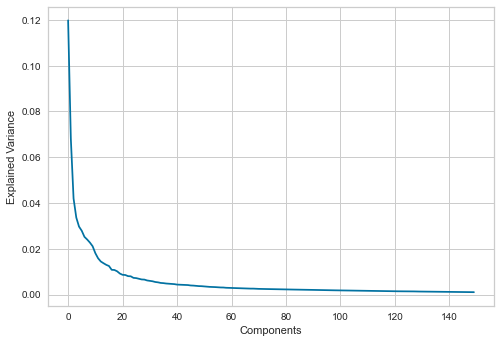

In [43]:
# Show the explained variance of the first two components
print(pca2.explained_variance_ratio_[:2])

# Plot the explained variance of the single principal components.
plt.plot(pca2.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

The first principal component explains ~12% of the variance, the second one only the 6.8%. Now we can create our reducted dataframe, with 151 columns against the starting 519 ones.

In [44]:
features_ = pd.DataFrame(features_red, columns = ['Comp_feat_%i' % i for i in range(150)])

# Re-add the track_id column by concat
features_pca = pd.concat([features['track_id'], features_], axis = 1)

features_pca.head()

,track_id,Comp_feat_0,Comp_feat_1,Comp_feat_2,Comp_feat_3,Comp_feat_4,Comp_feat_5,Comp_feat_6,Comp_feat_7,Comp_feat_8,...,Comp_feat_140,Comp_feat_141,Comp_feat_142,Comp_feat_143,Comp_feat_144,Comp_feat_145,Comp_feat_146,Comp_feat_147,Comp_feat_148,Comp_feat_149
0,2,2.060070,-3.089439,-5.565923,0.080540,2.309271,-3.597832,-5.054207,-0.889463,-5.108314,...,-0.257888,0.426989,0.222883,-0.286498,0.171627,0.091955,-0.371608,-0.297701,-0.163038,0.642569
1,3,3.509246,-5.384927,-4.332572,-1.113461,-3.068300,2.204037,-0.234569,4.726579,-0.604042,...,0.285206,0.456720,-0.625733,-0.167570,-0.543644,0.364137,0.100778,-0.403719,-0.468001,0.804260
2,5,0.954593,-3.178022,-3.494718,-0.934800,-1.098689,0.455750,-2.390566,1.266915,0.985001,...,0.696078,-0.261347,-0.100230,0.280217,0.493243,0.269762,-0.159173,0.058842,0.110906,0.157895
3,10,6.695430,1.329784,-5.129153,-0.915312,-2.155914,-0.120454,0.072620,3.904956,0.213871,...,-0.540870,0.220200,-0.514800,0.088469,-0.250212,0.546983,0.161909,0.261470,-0.178775,-0.366340
4,20,0.870800,-1.123613,2.985175,-0.830491,-2.443380,4.542687,-0.159430,-1.837120,1.026204,...,1.632813,-0.500091,-0.027587,-0.523349,0.256070,-0.319587,0.037620,-0.272229,0.595087,-0.529269


Now we can analyze the *tracks* dataframe.

In [45]:
tracks.columns

Index(['track_id', 'album_comments', 'album_date_created',
       'album_date_released', 'album_engineer', 'album_favorites', 'album_id',
       'album_information', 'album_listens', 'album_producer', 'album_tags',
       'album_title', 'album_tracks', 'album_type', 'artist_active_year_begin',
       'artist_active_year_end', 'artist_associated_labels', 'artist_bio',
       'artist_comments', 'artist_date_created', 'artist_favorites',
       'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude',
       'artist_members', 'artist_name', 'artist_related_projects',
       'artist_tags', 'artist_website', 'artist_wikipedia_page', 'set_split',
       'set_subset', 'track_bit_rate', 'track_comments', 'track_composer',
       'track_date_created', 'track_date_recorded', 'track_duration',
       'track_favorites', 'track_genre_top', 'track_genres',
       'track_genres_all', 'track_information', 'track_interest',
       'track_language_code', 'track_license', 'track_listens',
  

In [46]:
tracks.track_duration = (tracks.track_duration - tracks.track_duration.mean())/tracks.track_duration.std()

In [47]:
tracks[(tracks.track_language_code != "en") & (tracks.track_language_code != "")]

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
470,704,0,2008-11-26 02:16:37,2007-01-01 00:00:00,,3,199,"<p>2007's Macondo EP, released on the Fósforo'...",17169,,...,,2181,es,Attribution-NonCommercial-ShareAlike 3.0 Inter...,2105,,1,,[],Mano De Dios
471,705,0,2008-11-26 02:16:37,2007-01-01 00:00:00,,3,199,"<p>2007's Macondo EP, released on the Fósforo'...",17169,,...,,3240,es,Attribution-NonCommercial-ShareAlike 3.0 Inter...,2545,,2,,[],Tio Cocodrilo
472,706,0,2008-11-26 02:16:37,2007-01-01 00:00:00,,3,199,"<p>2007's Macondo EP, released on the Fósforo'...",17169,,...,,2699,es,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1948,,3,,[],Esto Es Califas
473,707,0,2008-11-26 02:16:37,2007-01-01 00:00:00,,3,199,"<p>2007's Macondo EP, released on the Fósforo'...",17169,,...,,2170,es,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1922,,5,,[],Cochabamba
474,708,0,2008-11-26 02:16:37,2007-01-01 00:00:00,,3,199,"<p>2007's Macondo EP, released on the Fósforo'...",17169,,...,,4581,es,Attribution-NonCommercial-ShareAlike 3.0 Inter...,5007,,6,,[],Desconocido
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99379,145049,0,2016-10-14 05:59:35,,,0,21646,,11232,,...,,1394,fr,Attribution-NonCommercial-ShareAlike,1265,,6,,[],B2 - V33
99380,145050,0,2016-10-14 05:59:35,,,0,21646,,11232,,...,,1752,fr,Attribution-NonCommercial-ShareAlike,1612,,7,,[],B3 - Une Fille comme les autres
99381,145051,0,2016-10-14 05:59:35,,,0,21646,,11232,,...,,2674,fr,Attribution-NonCommercial-ShareAlike,2380,,8,,[],B4 - Se Meurt
103094,149735,0,2017-01-21 08:59:58,2016-01-18 00:00:00,,0,22335,"<p>Released on tape with handmade cover, 50 co...",4141,,...,,3001,fr,Creative Commons Attribution-NonCommercial-NoD...,2744,,0,,[],"Concert à La Bascule, Rennes"


Some informations in *tracks* are really useful to identify the single track. So we decided to select some of these columns and keep them in our dataset.
The columns we select are: *album_id*, *album_title*, *artist_id*, *artist_name*, *track_title*, *track_bit_rate*, *track_duration*, *track_language_code*, *track_genre_top*

In [48]:
tracks_sel = tracks[['track_id', 'track_title', 'album_id', 'album_title', 'artist_id', 'artist_name', 'track_bit_rate',
                    'track_duration', 'track_language_code', 'track_genre_top']]
tracks_sel.head()

,track_id,track_title,album_id,album_title,artist_id,artist_name,track_bit_rate,track_duration,track_language_code,track_genre_top
0,2,Food,1,AWOL - A Way Of Life,1,AWOL,256000,-0.359550,en,Hip-Hop
1,3,Electric Ave,1,AWOL - A Way Of Life,1,AWOL,256000,-0.133704,en,Hip-Hop
2,5,This World,1,AWOL - A Way Of Life,1,AWOL,256000,-0.235171,en,Hip-Hop
3,10,Freeway,6,Constant Hitmaker,6,Kurt Vile,192000,-0.382462,en,Pop
4,20,Spiritual Level,4,Niris,4,Nicky Cook,256000,0.108507,en,


Finally, we can get our merged dataframe. We have noticed that these three different datasets contain different information about tracks but they have a common column: **track_id**. This ID number identifies in unambiguous way the track. 
We can check if there are some missing values in this column and if it is composed by all-unique values.

In [49]:
# Check if there are null values
print(tracks["track_id"].isnull().any())
print(features["track_id"].isnull().any())
print(echonest["track_id"].isnull().any())

False
False
False


In [50]:
# Check if the variable has only unique values.
print(len(tracks['track_id'].unique()) == len(tracks))
print(len(features['track_id'].unique()) == len(features))
print(len(echonest['track_id'].unique()) == len(echonest))

True
True
True


In [51]:
# Compute the merge between the reduted dataframe on the column 'track_id'
first_ = tracks_sel.merge(features_pca, on = "track_id")
merged_df = first_.merge(echonest_pca, on = "track_id")

print(merged_df.shape)
merged_df.head()

(13129, 240)


,track_id,track_title,album_id,album_title,artist_id,artist_name,track_bit_rate,track_duration,track_language_code,track_genre_top,...,Comp_echo_70,Comp_echo_71,Comp_echo_72,Comp_echo_73,Comp_echo_74,Comp_echo_75,Comp_echo_76,Comp_echo_77,Comp_echo_78,Comp_echo_79
0,2,Food,1,AWOL - A Way Of Life,1,AWOL,256000,-0.359550,en,Hip-Hop,...,0.182307,-0.529760,-0.013221,0.422226,-0.579445,-0.263976,0.410660,-1.264473,-0.266163,-0.273669
1,3,Electric Ave,1,AWOL - A Way Of Life,1,AWOL,256000,-0.133704,en,Hip-Hop,...,-0.473189,-0.882110,0.624207,0.400812,0.436491,-0.040015,-0.178589,-1.162560,-1.563780,0.907722
2,5,This World,1,AWOL - A Way Of Life,1,AWOL,256000,-0.235171,en,Hip-Hop,...,0.145065,-0.505266,0.225907,-0.332301,0.420514,-0.805920,-0.163618,-0.667805,-1.219136,-0.815777
3,10,Freeway,6,Constant Hitmaker,6,Kurt Vile,192000,-0.382462,en,Pop,...,-2.005337,1.527613,0.035180,0.933184,0.721974,-0.405923,-0.835324,0.518746,-0.490917,-0.006739
4,134,Street Music,1,AWOL - A Way Of Life,1,AWOL,256000,-0.231898,en,Hip-Hop,...,-0.217544,-0.435121,-0.085403,-0.660261,-0.699552,0.886126,0.573755,-0.721299,0.204571,0.723115


Our final dataframe is composed by 240 variables (a way less than the initial ones) and 13,129 observation. It means that we have selected only the observation contained in the *echonest* dataframe and we added informations from the other ones.

### **2.3 Clustering!**

We have implemented the function **K_Means** from scratch following the algorithm seen during our lessons. The initialization of centroid is random. The output of our function will be the euclidean distance between each point and its cluster and a dictionary where the keys are the clusters and for each one we have the indexes of the observations belonging to that cluster 

In [59]:
def K_Means(K, data):
    '''
    Input:
    K = number of clusters (integer)
    data = dataframe
    '''
    # Creating an array with the values of the dataframe
    array = np.array(data).reshape(data.shape[0], data.shape[1])
    
    n = array.shape[0]     # Number of rows
    m = array.shape[1]     # Number of columns
    
    # Picking randomly the first centroids
    centroids = array[np.random.choice(n, size = K, replace = False)]
    # Initialize the array of the previous centroids at each step of the algo
    prev_centroids = np.zeros((n,K)) 
    
    iterations = 0
    # Until the centroids don't change or the iterations are maximum n (the number of observation)
    while iterations != 100 or np.array_equal(centroids, prev_centroids) == False:
        # Saving the previous values of the cluster for the next while loop
        prev_centroids = centroids    
        euc_dis = np.zeros((n,K))      # Initialize the euclidean distance array
        clus = defaultdict(list)       # Collecting the clusters in a dictionary    
        clusters = []                  #list where I put the number of cluster for each element 
        
        for i in range(n):
            for j in range(K):
            # Computing the euclidean distance from each point to each centroid
                euc_dis[i][j] += linalg.norm(array[i]-centroids[j])
            
            # List containing the cluster to which each observation belongs to
            # Find the minimum distance between each observations and the clusters
            #I have to put [0][0] to extract the index where the obeservation has the min distance
            # We add '1' to get clusters that start from 1
            clusters.append(np.where(euc_dis[i] == min(euc_dis[i]))[0][0]+1)
            
            # Dictionary that maps each cluster to the observations that belong to it
            clus[clusters[i]].append(i)
        
        for k in range(K):
            for j in range(m):
                values = []
                for i in clus[k+1]: # Clusters start from value '1'
                    # Taking the values of the observation belonging to the i-th cluster
                    values.append(array[i][j])
                    
                # Computing the mean for each cluster and taking it as new centroid
                centroids[k][j] = np.mean(values)
        
        iterations += 1  # Pass at the next iteration
        
    return clusters, euc_dis, clus

Now, we can test our algorithm on the reducted and merged dataset we have. Before applying it, we need to remove all the string columns from the dataset, we can leverage the previous implemented function.

In [60]:
df_cl = remove_object_dtype(merged_df)

To find the optimal number of clusters we can use two different methods: the Elbow method and the Gap function. We implemented these from scratch, to fit them with our K-Means function.

In [61]:
clusters, euc_dis, clus =  K_Means(12, df_cl)

**1. Elbow Method**

In [62]:
def elbow(data, k):
    '''
    Input:
    data = dataframe
    k = max number of clusters (integer)
    '''
    cost = [] 
    
    for i in range(2,k): # The number of clusters analyzed goes from 2 to k
        # Run the implemented algorithm
        clusters, euc_dis, dictionary = K_Means(i, data)
        
        # Append the cost of the K-Means algorithm for each number of clusters
        #since we have to summation in the formula seen during lesson for the cost
        #it's faster to take all the minima distances from the nearest cluster for each obeservation
        #and sum all together
        cost.append(sum(euc_dis.min(axis=1)**2))
    
    x = list(range(2,k)) # Set the x-axis for the plot
    for i in range(1,len(cost)):
         # I want to compute the differences between contiguous cost 
         #to retrieve the optimal key 
         # I will not pick neither the minimum or the maximum difference
        diff = cost[i]-cost[i-1]
    # Plot the Elbow method
    plt.plot(x, cost, color = "orchid")
    plt.title("Elbow method")
    plt.xlabel("K")
    plt.ylabel("Cost")
    plt.show()
    
    return diff




        


The first method that we have used to choose the optimal number of cluster is the Elbow one. We could not use the YellowBrick library because we have not used the *KMeans* function of *sklearn* so we have implemented from scratch too. We have run our function *K_Means* for different values of k and for each one we have compute the cost and plot it. In practice cost can also increase for some k but then it keeps decreasing as usual.

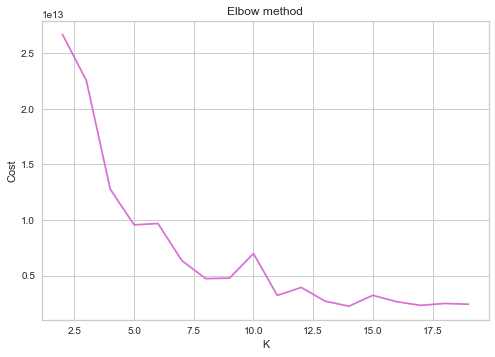

-65033732721.407715

In [63]:
elbow(df_cl, 20)

We have runned our Kmeans algorithm with 100 iterations and we have obtained a smooth elbow function that tells us that the number of optimal cluster is seven. Previously with less iteration we have obtained a rougher curve but the result was identical. Seven is a good result for us because running the algorithm *kmeans++* already implemented by *sklearn* and then check through *KElbowVisualizer* with the metric = "distortion" we will obtain the same results. 

2.Gap Statistics

To implement another method to find the optimal number of clusters we have read this article: https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad. 

After the Elbow method it advices to use firstly *Gap Statistics*. For us it is good because we already know how to compute the cost for each observation. The Gap Statistic formula is the following: 
$Gap_n(k)=E^*_n\{log(Cost_k)\}-log(Cost_k)$
In practice we have to generate reference data sets and cluster each of them with varying number of clusters. The reference datasets are created from a “continuous uniform” distribution using the *random_sample* function.
Then we have applied our function *K_Means* to the new reference dataset and compute the cost for each new random observation. Finally we are able to applied the final formula that gives us back the score.
The optimal number of cluster is K that is the one that gives back the max score.

In [64]:
# Create new random reference set
def gap_stat(data, k):
    #generate a new reference dataset
    randomReference = np.random.random_sample(size=data.shape)
    #cost of the original dataset
    cost = [] 
    #cost of the reference dataset
    cost_r = [] 
    #list of gap score
    gaps = []  
    #we start observing gap statistics with at least 2 cluster
    for i in range(2,k): 
        
        #kmeans for reference dataset
        clusters_r, euc_dis_r, dictionary_r = K_Means(i, randomReference) 
        #kmeans for original dataset
        clusters, euc_dis, dictionary = K_Means(i, data) 
        
        #summing all the euclidean distances to find the cost
        cost_ = sum(euc_dis.min(axis=1)**2) 
        cost.append(cost_)
        
        #summing all the euclidean distances to find the cost
        cost_r_ = sum(euc_dis_r.min(axis=1)**2) 
        cost_r.append(cost_r_)
        
        #computing the gaps statistic
        gap = np.log(np.mean(cost_r)) - np.log(cost_) 
        gaps.append(gap)
    plt.plot(list(range(2,k)), gaps, linestyle='--', marker='o', color='r')
    plt.title("Gap statistics")
    plt.xlabel("K")
    plt.ylabel("Gap Stistics")
    plt.show()
    maxx = max(gaps)
    #taking the k corresponding to the max gap statistic
    # +2 is due to because we start from k=2 instead the indexes start from 0
    return(gaps.index(maxx) + 2) 

    

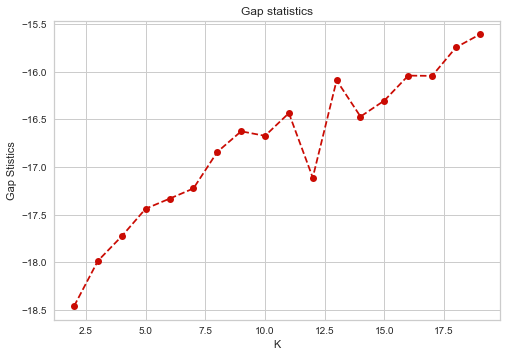

19

In [65]:
gap_stat(df_cl,20)

Through the *gap statistics* we obtain as optimal number of cluster 19. It is a value a bit different from what obtained before but the way in which we have computed this metric is totally different so we have thought that is not surprising. Indeed also built-in methods of *yellowbrick* give back completely different results among them.

In [ ]:
print(merged_df["track_genre_top"].unique())
print(len(merged_df["track_genre_top"].unique()))

In [ ]:
kmeans = KMeans(n_clusters=12, init='k-means++').fit(df_cl)
kmeans.cluster_centers_

### 2.3.4: use the already implemented version of k-means++ 

The differences between the two algorithm is in the initialization of the centroids. 

We have used the library *yellowbrick* to visualize the optimal number of clusters and we have used different kinds of metrics to compute it. 

The metric *distortion* gives us back as optimal number of cluster 7.

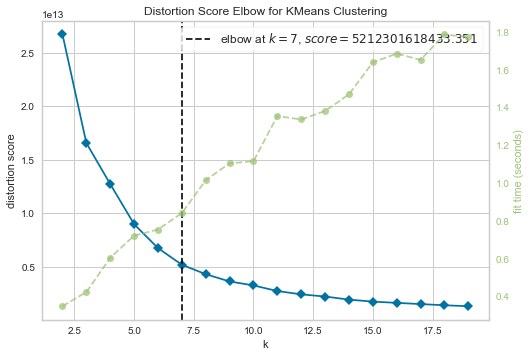

In [43]:
#Distortion
model = KMeans(init='k-means++')
visualizer = KElbowVisualizer(model, k = (2,20), metric = "distortion")
visualizer.fit(df_cl)
visualizer.show()

The metric *calinski_harabasz* and *silhouette* gives us back as optimal number of cluster 2. A really different result due to how these metrics are computed. 

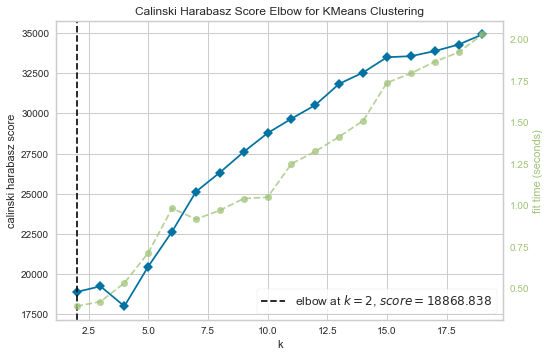

In [44]:
visualizer = KElbowVisualizer(model, k = (2,20), metric = "calinski_harabasz")
visualizer.fit(df_cl)
visualizer.show()

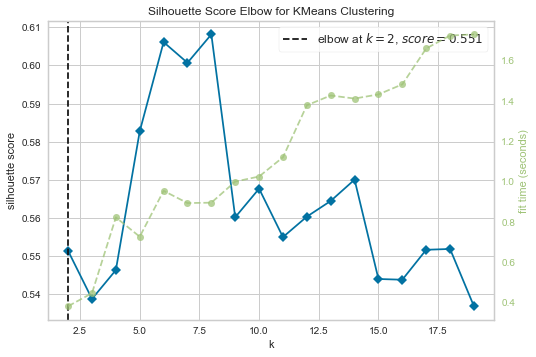

In [45]:
visualizer = KElbowVisualizer(model, k = (2,20), metric = "silhouette")
visualizer.fit(df_cl)
visualizer.show()

The way in which we have computed the cost for each K and consequently implemented the elbow method reproduce the metric *distortion* already implemented in the function *KElbowVisualizer* of the library *yellowbrick*. Indeed our optimal number of cluster obtained with the elbow method and this metric corrispond. As expected instead if we compute it with different metrics such as *silhouette* and *gap statistics*, the optimal number of cluster is different because it is computed with different criteria.

### 2.4 Analysing your results!

In [46]:
#We insert in our new dataframe the column "Cluster" corresponding to the cluster of that track.
df_cl.insert(1, "Clusters", clusters) 
df_cl

,track_id,Clusters,album_id,artist_id,track_bit_rate,track_duration,Comp_feat_0,Comp_feat_1,Comp_feat_2,Comp_feat_3,...,Comp_echo_70,Comp_echo_71,Comp_echo_72,Comp_echo_73,Comp_echo_74,Comp_echo_75,Comp_echo_76,Comp_echo_77,Comp_echo_78,Comp_echo_79
0,2,3,1,1,256000,-0.359550,2.060070,-3.089439,-5.565923,0.080540,...,0.215923,0.365999,-0.179212,0.492014,-0.654686,-0.122873,-0.001705,-0.718257,-0.753020,0.364727
1,3,3,1,1,256000,-0.133704,3.509246,-5.384927,-4.332572,-1.113460,...,-0.621101,0.575703,0.523199,0.471184,-0.187643,0.766380,-0.958213,-0.469377,-0.828162,0.885733
2,5,3,1,1,256000,-0.235171,0.954593,-3.178022,-3.494718,-0.934800,...,-0.023345,0.621719,0.362723,-0.769292,0.128186,-0.163764,-0.842425,0.232895,-1.358813,0.547057
3,10,2,6,6,192000,-0.382462,6.695430,1.329784,-5.129153,-0.915312,...,-1.543142,-1.545706,0.056314,-0.701839,1.105386,-0.063660,0.165455,1.079395,0.470370,0.551928
4,134,3,1,1,256000,-0.231898,0.704723,-6.843220,-2.639587,-1.228864,...,-0.466053,0.338143,-0.254234,-0.241083,-0.958332,0.426105,0.335439,-0.619336,0.134844,-0.285253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,124857,11,18862,20818,320000,-0.032237,5.654981,-5.399580,-0.732312,-0.470457,...,1.450046,1.230642,-0.382734,-0.946955,0.692692,-0.674328,0.101417,0.337884,-0.085071,0.677386
13125,124862,11,18862,20818,320000,-0.110792,14.575253,-3.654197,-1.060832,-1.135121,...,0.283812,0.305628,0.398207,0.249688,0.762256,0.040622,0.148435,1.640777,-0.495354,1.161883
13126,124863,11,18862,20818,320000,0.340899,16.215050,-4.070124,-2.227104,0.181623,...,1.040321,0.203973,-0.831766,-0.736973,0.055574,-1.238309,0.466977,0.953245,0.045090,0.846136
13127,124864,11,18862,20818,320000,0.039771,-2.644731,-2.042654,-2.478634,-0.733207,...,-0.807310,0.446368,-0.657210,0.149972,-0.094513,0.553070,-0.118881,0.814861,0.123448,0.524492


To identify the genre of a song we have selected six features: as suggested we have picked *track_language* and *track_duration*. Moreover we have surfed on internet to understand what are the important feature to understand the genre of a song. We have come up with the following features: *audio_features_acousticness*, *audio_features_danceability*, *audio_features_energy*, *audio_features_instrumentalness*. They are all numerical features except for *track_language*. As requested we have categorized each them in four categories through the function of pandas *cut* or *qcut*.

Before of the catgorization we have standardized these features, in particular we have had some troubles with the track duration because there were outliers that have driven to wrong categorization. 

In [47]:
pivot = pd.DataFrame()
a = []
for i in range(1,5):
    pivot.insert(i-1, echonest.columns[i], pd.cut(echonest[echonest.columns[i]], bins = 4,labels=["1", "2", "3", "4"])) 
pivot.insert(0,"track_duration", pd.qcut(df_cl[df_cl.columns[5]], q = 4,labels=["1", "2", "3", "4"]))
pivot["track_language"] = tracks.track_language_code
pivot.insert(0, "Clusters", clusters)
pivot

,Clusters,track_duration,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,track_language
0,3,2,2,3,3,1,en
1,3,3,2,3,4,1,en
2,3,2,1,4,3,1,en
3,2,2,4,3,4,4,en
4,3,2,2,3,3,1,en
...,...,...,...,...,...,...,...
13124,11,3,1,4,3,4,en
13125,11,3,1,4,3,4,en
13126,11,4,1,3,4,4,en
13127,11,4,2,3,3,2,en


### Pivot

We do not know why the funtion *np.round* does not work properly and so in pivot table we have percentages like 99.9999% or 100.0001% due to numerical issues.

In [48]:
#acoustiness
t = np.zeros((4,12))
l = []
for j in range(0,4):
    for i in range(0,12):
        t[j][i] = ((pivot[(pivot.audio_features_acousticness == str(j+1)) & (pivot.Clusters == i+1)].count()[0]))

for i in range(t.shape[1]):
    t[:,i] = np.round((t[:,i]/sum(t)[i])*100, 2)
l = []
for i in range(1,13):
    l.append("Cluster "+str(i))
acoustiness_pivot = pd.DataFrame(t)
acoustiness_pivot.columns = l
acoustiness_pivot.loc[4] = sum(t)
acoustiness_pivot = acoustiness_pivot.rename(index={0: 'Category 1',1: 'Category 2',2: 'Category 3', 3: 'Category 4'})
acoustiness_pivot.rename(index={4: 'Tot'})


,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12
Category 1,42.81,31.11,17.56,21.56,40.27,46.79,25.65,23.46,44.32,61.82,57.26,40.69
Category 2,13.79,13.64,10.95,9.72,14.33,11.48,10.48,9.50,13.03,11.93,15.73,13.18
Category 3,11.63,15.48,14.88,14.59,13.53,11.40,10.48,9.50,13.31,12.80,8.38,12.52
Category 4,31.77,39.77,56.61,54.13,31.87,30.33,53.38,57.54,29.34,13.45,18.63,33.61
Tot,100.00,100.00,100.00,100.00,100.00,100.00,99.99,100.00,100.00,100.00,100.00,100.00


**Acoustiness pivot**: for the first, third, ninth, tenth and twelveth cluster the first category is prevalent, while the fourth one is prevalent in the second, fourth, fifth, sixth, seventh, eight, eleventh cluster. While the second and the third categories give a smaller contribute in the total percentage. 

In [49]:
np.around(100.1, 0)

100.0

In [50]:
#danceability
t = np.zeros((4,12))
l = []
for j in range(0,4):
    for i in range(0,12):
        t[j][i] = ((pivot[(pivot.audio_features_danceability == str(j+1)) & (pivot.Clusters == i+1)].count()[0]))

for i in range(t.shape[1]):
    t[:,i] = np.around((t[:,i]/sum(t)[i])*100,4)
l = []
for i in range(1,13):
    l.append("Cluster "+str(i))
danceability_pivot = pd.DataFrame(t)
danceability_pivot.columns = l
danceability_pivot.loc[4] = sum(t)

danceability_pivot = danceability_pivot.rename(index={0: 'Category 1',1: 'Category 2',2: 'Category 3', 3: 'Category 4'})
danceability_pivot.rename(index={4: 'Tot'})

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12
Category 1,12.7098,15.6889,21.0009,17.8503,12.0096,20.7369,19.2565,17.3184,9.0592,11.4967,6.8376,13.1796
Category 2,34.8921,33.3561,50.4021,43.5061,31.2250,47.1294,38.5130,39.6648,26.6899,39.6963,29.2308,32.2900
Category 3,41.1271,37.4488,24.6202,30.9661,40.1922,28.1063,31.4498,33.5196,42.8571,42.0824,46.6667,43.1631
Category 4,11.2710,13.5061,3.9768,7.6775,16.5733,4.0274,10.7807,9.4972,21.3937,6.7245,17.2650,11.3674
Tot,100.0000,99.9999,100.0000,100.0000,100.0001,100.0000,100.0000,100.0000,99.9999,99.9999,100.0001,100.0001


**Danceability pivot**: The fourth category gives the smallest contribution to almost each cluster (except the ninth and the last one). In contrast to the acoustiness pivot we obtained a more balanced contribution from the first three categories. The first category is never the most representative category for any cluster. In cluster 6 the second category represent the 51.6% of the total.

In [51]:
#energy
t = np.zeros((4,12))
l = []
for j in range(0,4):
    for i in range(0,12):
        t[j][i] = ((pivot[(pivot.audio_features_energy == str(j+1)) & (pivot.Clusters == i+1)].count()[0]))

for i in range(t.shape[1]):
    t[:,i] = np.around((t[:,i]/sum(t)[i])*100, 2)
l = []
for i in range(1,13):
    l.append("Cluster "+str(i))
energy_pivot = pd.DataFrame(t)
energy_pivot.columns = l
energy_pivot.loc[4] = sum(t)
energy_pivot = energy_pivot.rename(index={0: 'Category 1',1: 'Category 2',2: 'Category 3', 3: 'Category 4'})
energy_pivot.rename(index={4: 'Tot'})

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12
Category 1,16.79,11.46,22.39,25.85,19.38,11.48,26.77,40.78,15.19,9.11,11.62,20.10
Category 2,26.14,25.03,26.41,23.29,30.42,20.99,23.49,22.35,26.62,23.64,22.56,25.04
Category 3,29.62,32.88,27.21,27.45,27.54,27.93,21.93,22.91,32.54,31.02,32.31,29.00
Category 4,27.46,30.63,23.99,23.42,22.66,39.59,27.81,13.97,25.64,36.23,33.50,25.86
Tot,100.01,100.00,100.00,100.01,100.00,99.99,100.00,100.01,99.99,100.00,99.99,100.00


**Energy pivot**: For the sixth cluster we can notice that all the four categories give almost the same contribute and the same event happens in cluster 11. In the third and tenth cluster the last category contributes for the major part to the total, while in the first and third cluster the contribution of the first category is less than 10%.  

In [52]:
#instrumentalness
t = np.zeros((4,12))
l = []
for j in range(0,4):
    for i in range(0,12):
        t[j][i] = ((pivot[(pivot.audio_features_instrumentalness == str(j+1)) & (pivot.Clusters == i+1)].count()[0]))

for i in range(t.shape[1]):
    t[:,i] = np.around((t[:,i]/sum(t)[i])*100,4)
l = []
for i in range(1,13):
    l.append("Cluster "+str(i))
instrumentalness_pivot = pd.DataFrame(t)
instrumentalness_pivot.columns = l
instrumentalness_pivot.loc[4] = sum(t)
instrumentalness_pivot = instrumentalness_pivot.rename(index={0: 'Category 1',1: 'Category 2',2: 'Category 3', 3: 'Category 4'})
instrumentalness_pivot.rename(index={4: 'Tot'})

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12
Category 1,31.2950,17.7353,18.2752,12.4120,17.5340,37.2751,20.8178,22.9050,13.6585,56.6161,44.6154,40.3624
Category 2,4.7962,5.1842,6.7024,5.9501,5.7646,6.0840,5.5019,5.5866,4.2509,6.5076,7.0085,6.2603
Category 3,10.6715,10.5048,11.7516,9.4050,13.1305,9.9400,10.2602,9.4972,8.7108,13.4490,10.0855,7.2488
Category 4,53.2374,66.5757,63.2708,72.2329,63.5709,46.7009,63.4201,62.0112,73.3798,23.4273,38.2906,46.1285
Tot,100.0001,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000


In [53]:
#duration
t = np.zeros((4,12))
l = []
for j in range(0,4):
    for i in range(0,12):
        t[j][i] = ((pivot[(pivot.track_duration == str(j+1)) & (pivot.Clusters == i+1)].count()[0]))

for i in range(t.shape[1]):
    t[:,i] = np.around((t[:,i]/sum(t)[i])*100,4)
l = []
for i in range(1,13):
    l.append("Cluster "+str(i))
track_duration_pivot = pd.DataFrame(t)
track_duration_pivot.columns = l
track_duration_pivot.loc[4] = sum(t)
track_duration_pivot = track_duration_pivot.rename(index={0: 'Category 1',1: 'Category 2',2: 'Category 3', 3: 'Category 4'})
track_duration_pivot.rename(index={4: 'Tot'})

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12
Category 1,25.5396,30.6958,27.8820,24.9520,23.2986,23.3933,27.3606,14.5251,20.6969,19.0889,17.9487,28.3361
Category 2,25.7794,26.0573,23.3244,29.4946,22.4980,26.1354,28.1041,32.4022,20.9756,31.4534,19.8291,25.5354
Category 3,26.3789,22.6467,21.0009,23.2246,25.7006,25.1071,24.5353,21.2291,27.7352,31.6703,29.9145,27.0181
Category 4,22.3022,20.6003,27.7927,22.3289,28.5028,25.3642,20.0000,31.8436,30.5923,17.7874,32.3077,19.1104
Tot,100.0001,100.0001,100.0000,100.0001,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000


**Duration pivot**: In this pivot table each category gives a contribution similar to the other categories, around the 25%, there are just little oscillation from this value. We have thought that is due to the fact that we have standardized this feature.

Following the instructions of the homework we have thought to choose *language* as a variable of interest. But then we have noticed that circa the 90% of the observations have a language not defined so take it as a variable of interest is useless. Indeed as shown in the pivot table the first category, that represents NaN values gives a contribution at least equals to 93%. The second category instead represents the english language that is the more frequent language present in the dataframe. 

In [54]:
#language
t = np.zeros((len(pivot.track_language.unique()),12))
l = []
c = 0 
for j in pivot.track_language.unique():
    for i in range(0,12):
        t[c][i] = ((pivot[(pivot.track_language == j) & (pivot.Clusters == i+1)].count()[0]))
    c += 1
for i in range(t.shape[1]):
    t[:,i] = np.around((t[:,i]/sum(t)[i])*100,4)
l = []
for i in range(1,13):
    l.append("Cluster "+str(i))
track_language_pivot = pd.DataFrame(t)
track_language_pivot.columns = l
track_language_pivot.loc[len(pivot.track_language.unique())+1] = sum(t)

track_language_pivot

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12
0,97.3621,97.4079,99.3298,97.2489,94.7958,97.9434,97.6952,91.6201,96.7944,96.9631,98.8034,97.5288
1,2.6379,0.5457,0.2234,0.6398,0.3203,1.2853,0.9665,2.2346,0.4181,1.5184,0.1709,0.0000
2,0.0000,0.3411,0.0447,1.0877,0.8807,0.0857,0.0743,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.1714,0.0743,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.1787,0.0000,0.2402,0.0000,0.3717,0.0000,0.0000,0.0000,0.1709,0.3295
5,0.0000,0.2046,0.1340,0.0640,0.7206,0.0000,0.4461,1.1173,0.0697,0.0000,0.0000,0.0000
6,0.0000,0.0000,0.0447,0.0000,0.4003,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.0000,0.0682,0.0000,0.0640,0.4003,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.0000,0.2046,0.0447,0.0000,0.3203,0.0000,0.0743,0.0000,0.1394,0.0000,0.0000,0.0000
9,0.0000,0.0000,0.0000,0.0640,0.7206,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [55]:
tra = pd.DataFrame(merged_df["track_genre_top"])
tra["Clusters"] = df_cl["Clusters"]
tra = tra[tra.track_genre_top != ""]
tra = tra[tra.track_genre_top != ""].reset_index()
tra.track_genre_top.unique()
t = np.zeros((len(tra.track_genre_top.unique()),12))
l = []
c = 0 
for j in tra.track_genre_top.unique():
    for i in range(0,12):
        t[c][i] = ((tra[(tra.track_genre_top == j) & (tra.Clusters == i+1)].count()[0]))
    c += 1
for i in range(t.shape[1]):
    t[:,i] = np.around((t[:,i]/sum(t)[i])*100,4)
l = []
for i in range(1,13):
    l.append("Cluster "+str(i))
track_genre = pd.DataFrame(t)
track_genre.columns = l
track_genre.loc[len(tra.track_genre_top.unique())] = sum(t)

track_genre = track_genre.rename(index={0: 'Hip-Hop', 1: 'Pop', 2: 'Folk', 3: 'Jazz', 
                                        4: 'Rock', 5: 'Electronic', 6: 'International',
                                        7: 'Blues', 8: 'Classical', 9: 'Old-Time / Historic', 10: 'Instrumental',
                                        11: 'Experimental'})
track_genre.rename(index={12: 'Tot'})

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12
Hip-Hop,10.4046,15.9266,5.4967,2.1257,16.2134,4.2079,10.2002,17.6,16.7651,6.9930,14.0065,10.0840
Pop,9.8266,2.0270,2.4710,1.3863,5.3347,3.9604,2.5739,6.4,8.3825,1.3986,2.6059,2.5210
Folk,10.4046,8.3012,15.9355,6.2847,4.9163,7.1782,11.0582,8.0,6.3754,11.1888,1.3029,8.1232
Jazz,1.5414,2.7027,1.8659,2.3105,4.7071,3.7129,2.8599,4.8,2.9516,0.3497,0.3257,1.4006
Rock,40.0771,34.7490,60.0605,42.7911,23.5356,70.1733,29.9333,27.2,20.7792,57.3427,20.1954,35.8543
Electronic,24.4701,34.0734,9.4806,19.8706,37.6569,7.4257,21.0677,12.0,39.4333,12.5874,49.1857,30.8123
International,0.0000,0.2896,2.6727,1.7560,0.0000,3.2178,0.7626,0.0,1.4168,2.4476,1.6287,0.0000
Blues,0.0000,0.8687,0.9077,1.6636,0.2092,0.0000,1.8112,0.0,0.0000,0.0000,0.0000,0.0000
Classical,0.0000,0.4826,1.0086,2.6802,4.0795,0.1238,8.8656,15.2,2.2432,0.0000,0.0000,11.2045
Old-Time / Historic,1.1561,0.0965,0.1009,19.0388,0.0000,0.0000,10.4862,8.0,0.0000,0.6993,6.5147,0.0000


- **Experimental**: It contributes for just the 2.1% to the first cluster and for the 0.7% to the ninth cluster while for the other cluster its contribution is equal to zero.

- **Instrumental**: It gives a contribution equal to zero to four cluster(1, 3, 6, 12) while its major contribuite is in the cluster 10 with circa 7%.

- **Old-Time/Historic**: it contributes for the 19% to the cluster 4 and its contribution for cluster 7 is also greater than 10%, while for cluster 5, 6, 9 and 12 its contribution is zero.

- **Classical**: it give its main contribution to cluster 8 with 15.2% while for the cluster is 11.2%. In cluster 1, 10 and 11 it is not present.

- **Blues**: its contribution to each cluster is always less than 2%, for more than the half of clusters its contribution is zero

- **International**: its main contribution is to cluster six with a percentage of circa 3.2%, while it does not contribute to cluster 1, 5, 8 and 12, while the other percentage are about 1-2%.

Until now I have commented genres that are a bit secondary in our dataframe, their percentages are always smaller than 20%. 

- **Electronic**: it contributes to each cluster with at least a percentage greater than 7%. It compose almost the half of the cluster 11 and more than the 30% of the cluster 2, 5, 9 and 12.

- **Rock**: it is the genre that has the highest percentages in 8 cluster over 12, so we can conclude that tracks that are present in our dataframe belong for the major part to this genre. It compose the 70% of cluster 6. and 60% of cluster 3.

- **Jazz**: is a more particular genre so it is more rare in spite of rock, but it contributes to each cluster. Its percentages are always smaller than 5%

- **Folk**: except for the cluster 11, its percentage are always over the 4% and for cluster 1,3,7 and 10 they are even over the 10%.

- **Pop**: its percentage are not very high: just for cluster 1, 5, 8 and 9 they are over the 5% and neither of them is over the 10%

- **Hip-Hop**: it contributes with a few percentage to cluster 3, 4, 6 and 10 (circa 5.5%, 2%, 4% and 7%) while for the other cluster its percentages are always over 10%.


**2.7** *Execute your K-Means++ Analysis again, but don't use the variables from echonest.csv. It will leave you with ~100K songs.*

Now, we have only two datasets: *tracks* and *features*. Before merging them, we can reduce their dimensionality following the steps of the previous exercise.

In [33]:
# Pick the scaled and filled dataframe
features_s.head()

,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,2,0.208784,0.452353,-0.008553,0.056482,0.079044,0.017718,0.071164,0.152168,0.090291,...,-1.200560,-1.537657,-1.595043,-0.266432,0.425841,1.007362,0.874131,-0.454603,-0.369213,0.775698
1,3,0.044880,0.050426,0.001063,0.106160,0.090461,-0.020371,0.064405,0.046439,-0.012742,...,-0.938948,-1.210805,-0.675913,-0.299409,0.463112,0.975158,0.643107,-0.454603,-0.491744,1.064853
2,5,0.002712,-0.024945,-0.061548,0.021789,0.109332,0.046419,-0.070494,-0.081502,0.063099,...,-1.561604,-1.461126,-1.162622,-0.254636,-0.034719,0.011006,-0.065367,-0.454603,-0.335249,0.167182
3,10,0.101044,-0.044147,0.186567,-0.026460,0.071382,0.056075,0.088195,0.081984,0.043355,...,-0.655213,-0.595296,-1.299392,-0.090255,0.385908,0.758699,0.889532,-0.454603,0.107731,0.018234
4,20,-0.019632,-0.035814,-0.013339,-0.000614,0.031972,-0.018958,-0.033153,-0.074345,-0.021467,...,-0.098756,0.151932,-0.085646,-0.143811,0.481748,-0.169453,-0.111572,-0.265064,-0.008018,-0.341557


In [48]:
# Now we set the number of principal components at 90, because we have less variables in total
# so we can obtain also a bit less total explained variance a the end.
pca3 = PCA(n_components=90)

# We don't want to perform it on the track_id column
features_red1 = pca3.fit_transform(features_s[features_s.columns[1:]])

# Show the total explained variance ratio
print(sum(pca3.explained_variance_ratio_))

0.808986398830857


If we set 90 as number of principal components we get ~80% of explained total variance. That is our target, because at the end we want to preserve almost the 70% of the total variance of the merged dataset. Let's see in particular, how much variance is explained by every single component.

[0.11981209 0.06802443]


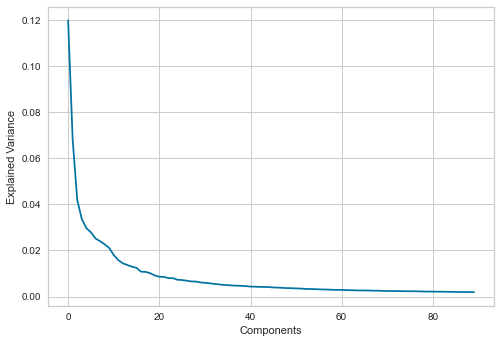

In [49]:
# Show the explained variance of the first two components
print(pca3.explained_variance_ratio_[:2])

# Plot the explained variance of the single principal components.
plt.plot(pca3.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

Obviously, we get the same results of the previous analysis in term of single principal components, the only difference is that, in this case, they are only 90 and not 150. The first principal component explains ~12% of the variance, the second one only the 6.8%. Now we can create our reducted dataframe, with 91 columns against the starting 519 ones.

In [50]:
features_1 = pd.DataFrame(features_red1, columns = ['Comp_feat_%i' % i for i in range(90)])

# Re-add the track_id column by concat
features_pca1 = pd.concat([features['track_id'], features_1], axis = 1)

features_pca1.head()

,track_id,Comp_feat_0,Comp_feat_1,Comp_feat_2,Comp_feat_3,Comp_feat_4,Comp_feat_5,Comp_feat_6,Comp_feat_7,Comp_feat_8,...,Comp_feat_80,Comp_feat_81,Comp_feat_82,Comp_feat_83,Comp_feat_84,Comp_feat_85,Comp_feat_86,Comp_feat_87,Comp_feat_88,Comp_feat_89
0,2,2.060070,-3.089439,-5.565921,0.080538,2.309279,-3.597830,-5.054210,-0.889491,-5.108311,...,-0.419052,-0.417361,-0.316358,-0.050867,-0.262169,-0.215504,0.699760,1.283379,-0.862916,0.845444
1,3,3.509246,-5.384927,-4.332570,-1.113462,-3.068311,2.204021,-0.234586,4.726587,-0.604043,...,0.558156,-0.163046,0.396114,-0.101973,0.632744,0.517722,-0.138267,-0.251875,-0.600215,0.050384
2,5,0.954593,-3.178022,-3.494725,-0.934803,-1.098671,0.455771,-2.390572,1.266868,0.985002,...,0.484078,1.015728,-0.427635,-0.258285,-0.832134,1.096446,0.001451,0.201388,0.014982,0.028133
3,10,6.695430,1.329784,-5.129156,-0.915316,-2.155925,-0.120450,0.072604,3.904926,0.213880,...,-0.255745,0.639006,0.733231,0.424312,-0.759441,-0.770036,0.455665,0.365240,-0.077288,0.769210
4,20,0.870800,-1.123613,2.985178,-0.830489,-2.443364,4.542686,-0.159455,-1.837099,1.026176,...,-0.052422,-0.712299,0.015921,0.429293,-0.893356,0.796459,-0.689550,0.651899,0.969139,-1.197378


Now, we can select from the *tracks* dataset the same columns as before. So, we recall the dataset *tracks_sel*.

In [51]:
tracks_sel.head()

,track_id,track_title,album_id,album_title,artist_id,artist_name,track_bit_rate,track_duration,track_language_code,track_genre_top
0,2,Food,1,AWOL - A Way Of Life,1,AWOL,256000,-0.359550,en,Hip-Hop
1,3,Electric Ave,1,AWOL - A Way Of Life,1,AWOL,256000,-0.133704,en,Hip-Hop
2,5,This World,1,AWOL - A Way Of Life,1,AWOL,256000,-0.235171,en,Hip-Hop
3,10,Freeway,6,Constant Hitmaker,6,Kurt Vile,192000,-0.382462,en,Pop
4,20,Spiritual Level,4,Niris,4,Nicky Cook,256000,0.108507,en,


Now, we can merge the two reducted dataframes on their common column: **track_id**.

In [52]:
second_df = tracks_sel.merge(features_pca1, on = "track_id")

# Give a quick look at the new merged dataframe
print(second_df.shape)
second_df.head()

(106574, 100)


,track_id,track_title,album_id,album_title,artist_id,artist_name,track_bit_rate,track_duration,track_language_code,track_genre_top,...,Comp_feat_80,Comp_feat_81,Comp_feat_82,Comp_feat_83,Comp_feat_84,Comp_feat_85,Comp_feat_86,Comp_feat_87,Comp_feat_88,Comp_feat_89
0,2,Food,1,AWOL - A Way Of Life,1,AWOL,256000,-0.359550,en,Hip-Hop,...,-0.419052,-0.417361,-0.316358,-0.050867,-0.262169,-0.215504,0.699760,1.283379,-0.862916,0.845444
1,3,Electric Ave,1,AWOL - A Way Of Life,1,AWOL,256000,-0.133704,en,Hip-Hop,...,0.558156,-0.163046,0.396114,-0.101973,0.632744,0.517722,-0.138267,-0.251875,-0.600215,0.050384
2,5,This World,1,AWOL - A Way Of Life,1,AWOL,256000,-0.235171,en,Hip-Hop,...,0.484078,1.015728,-0.427635,-0.258285,-0.832134,1.096446,0.001451,0.201388,0.014982,0.028133
3,10,Freeway,6,Constant Hitmaker,6,Kurt Vile,192000,-0.382462,en,Pop,...,-0.255745,0.639006,0.733231,0.424312,-0.759441,-0.770036,0.455665,0.365240,-0.077288,0.769210
4,20,Spiritual Level,4,Niris,4,Nicky Cook,256000,0.108507,en,,...,-0.052422,-0.712299,0.015921,0.429293,-0.893356,0.796459,-0.689550,0.651899,0.969139,-1.197378


Our final dataframe is composed by 100 variables and 106,574 observation. We have much more observations here, but less variables.

Now, we can perform the **K-means++** on this data. Before, we need to consider only the numeric variables. So we pass the dataframe into the function *remove_object_dtype*.

In [64]:
df_cl1 = remove_object_dtype(second_df)

In [65]:
# Set the number of clusters at 12 and specify that we want k-means++ algorithm
kmeans1 = KMeans(n_clusters = 12, init = 'k-means++').fit(df_cl1)

In [66]:
clusters = kmeans1.predict(df_cl1)

We find the optimal number of clusters with the library *yellowbrick*. This allows us to visualize the optimal number of clusters and to use different kinds of metrics to compute it.

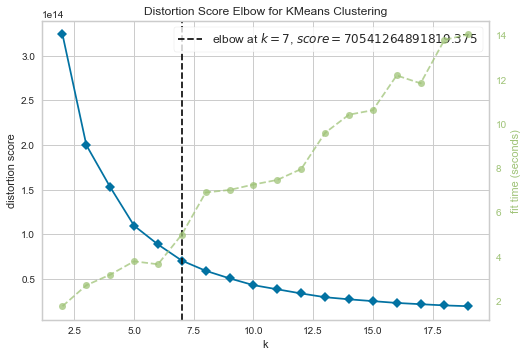

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
#Distortion
model_1 = KMeans(init = 'k-means++')
visualizer = KElbowVisualizer(model_1, k = (2,20), metric = "distortion")
visualizer.fit(df_cl1)
visualizer.show()

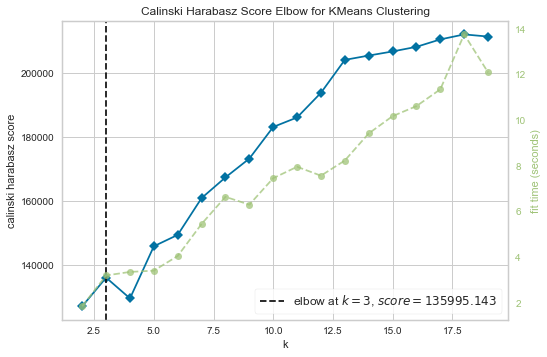

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [49]:
visualizer = KElbowVisualizer(model_1, k = (2,20), metric = "calinski_harabasz")
visualizer.fit(df_cl1)
visualizer.show()

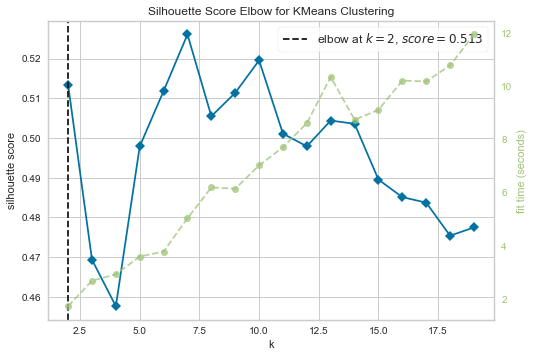

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [52]:
visualizer = KElbowVisualizer(model_1, k = (2,20), metric = "silhouette")
visualizer.fit(df_cl1)
visualizer.show()

*Characterize your clusters using 5-10 variables.*

In [67]:
#We insert in our new dataframe the column "Cluster" corresponding to the cluster of that track.
df_cl1.insert(1, "Clusters", clusters) 
df_cl1

,track_id,Clusters,album_id,artist_id,track_bit_rate,track_duration,Comp_feat_0,Comp_feat_1,Comp_feat_2,Comp_feat_3,...,Comp_feat_80,Comp_feat_81,Comp_feat_82,Comp_feat_83,Comp_feat_84,Comp_feat_85,Comp_feat_86,Comp_feat_87,Comp_feat_88,Comp_feat_89
0,2,5,1,1,256000,-0.359550,2.060070,-3.089439,-5.565921,0.080538,...,-0.419052,-0.417361,-0.316358,-0.050867,-0.262169,-0.215504,0.699760,1.283379,-0.862916,0.845444
1,3,5,1,1,256000,-0.133704,3.509246,-5.384927,-4.332570,-1.113462,...,0.558156,-0.163046,0.396114,-0.101973,0.632744,0.517722,-0.138267,-0.251875,-0.600215,0.050384
2,5,5,1,1,256000,-0.235171,0.954593,-3.178022,-3.494725,-0.934803,...,0.484078,1.015728,-0.427635,-0.258285,-0.832134,1.096446,0.001451,0.201388,0.014982,0.028133
3,10,9,6,6,192000,-0.382462,6.695430,1.329784,-5.129156,-0.915316,...,-0.255745,0.639006,0.733231,0.424312,-0.759441,-0.770036,0.455665,0.365240,-0.077288,0.769210
4,20,5,4,4,256000,0.108507,0.870800,-1.123613,2.985178,-0.830489,...,-0.052422,-0.712299,0.015921,0.429293,-0.893356,0.796459,-0.689550,0.651899,0.969139,-1.197378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106569,155316,1,22940,24357,320000,-0.379188,4.521111,3.592298,4.814328,0.176409,...,0.305575,-0.688037,0.513278,0.400080,-0.106556,1.238978,0.821518,-0.020024,0.689208,0.036862
106570,155317,1,22940,24357,320000,-0.199167,2.857393,-1.721085,6.610440,-0.152464,...,-0.108477,-0.912392,-0.026241,-0.309114,0.579352,0.065603,2.096478,0.846289,0.182098,1.123883
106571,155318,1,22940,24357,320000,0.412907,5.175002,-1.204843,1.603658,-0.319237,...,0.737757,-0.001886,0.566770,0.048681,-0.232060,1.378595,1.325433,-0.655221,-0.391001,0.671826
106572,155319,1,22940,24357,320000,-0.431558,8.265668,0.375063,2.059374,0.260034,...,1.251453,0.810190,-0.121077,-1.481882,-0.655976,0.564264,1.091396,-0.086402,-0.689521,0.236742


Now we have characterized our cluster with six variables: *track_duration* as before, and since we have not anymore the echonest dataframe we have chosen the *track_bitrate*: it is a variable that is important for the quality of the audio.  Then we have chosen *zcr_mean* and *zcr_median*; zero-crossing rate its value has been widely used in both speech recognition and music information retrieval, being a key feature to classify percussive sounds.
Finally we have picked *rmse_mean* and *rmse_median*,that represent the mean and the median of the root-mean-square (RMS) energy for each frame. 

In [85]:
pivot = pd.DataFrame()
a = []
pivot.insert(0, 'track_duration', pd.qcut(df_cl1[df_cl1.columns[5]], q = 4, labels=["1", "2", "3", "4"]))
pivot.insert(0, 'track_bitrate', pd.cut(df_cl1[df_cl1.columns[4]], bins = 4, labels=["1", "2", "3", "4"]))
pivot.insert(0, 'rmse_median', pd.qcut(features_s.rmse_median_01, q = 4, labels=["1", "2", "3", "4"]))
pivot.insert(0, 'rmse_mean', pd.qcut(features_s.rmse_mean_01, q = 4, labels=["1", "2", "3", "4"]))
pivot.insert(0, 'zcr_median', pd.qcut(features_s.zcr_median_01, q = 4, labels=["1", "2", "3", "4"]))
pivot.insert(0, 'zcr_mean', pd.qcut(features_s.zcr_mean_01, q = 4, labels=["1", "2", "3", "4"]))
pivot.insert(0, "Clusters", clusters)
pivot


,Clusters,zcr_mean,zcr_median,rmse_mean,rmse_median,track_bitrate,track_duration
0,5,4,4,2,2,3,2
1,5,4,4,2,2,3,3
2,5,3,3,2,2,3,2
3,9,4,4,2,3,2,2
4,5,3,3,3,3,3,4
...,...,...,...,...,...,...,...
106569,1,1,2,2,3,3,2
106570,1,1,2,2,2,3,3
106571,1,2,2,2,2,3,4
106572,1,2,3,2,2,3,1


In [86]:
#duration
t = np.zeros((4,12))
l = []
for j in range(0,4):
    for i in range(0,12):
        t[j][i] = ((pivot[(pivot.track_duration == str(j+1)) & (pivot.Clusters == i)].count()[0]))

for i in range(t.shape[1]):
    t[:,i] = np.around((t[:,i]/sum(t)[i])*100,4)
l = []
for i in range(1,13):
    l.append("Cluster "+str(i))
track_duration_pivot = pd.DataFrame(t)
track_duration_pivot.columns = l
track_duration_pivot.loc[4] = sum(t)
track_duration_pivot = track_duration_pivot.rename(index={0: 'Category 1',1: 'Category 2',2: 'Category 3', 3: 'Category 4'})
track_duration_pivot.rename(index={4: 'Tot'})

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12
Category 1,27.7260,19.6824,23.2006,26.2180,36.4626,26.9504,26.4828,23.7664,22.3368,31.7733,23.2902,29.8978
Category 2,24.8792,24.9836,23.5659,25.7659,25.4108,26.1626,25.8790,25.9375,23.8356,26.9146,23.7061,25.3906
Category 3,23.8440,26.0880,26.5400,27.0342,19.0222,21.5341,23.7836,27.7303,26.8251,21.4658,26.8484,20.9135
Category 4,23.5507,29.2460,26.6935,20.9819,19.1044,25.3529,23.8546,22.5658,27.0024,19.8463,26.1553,23.7981
Tot,99.9999,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,99.9999,100.0000,100.0000,100.0000


**Duration pivot**: Since we have used the function *qcut* we have divided the observations according the quartiles so as expected the pivot table is well balanced since in each cluster there is more or less a quarter of each category. Only in the clusters 5 and 10 there are percentages over the 30%

In [87]:
# Track Bitrate
t = np.zeros((4,12))
l = []
for j in range(0,4):
    for i in range(0,12):
        t[j][i] = ((pivot[(pivot.track_bitrate == str(j+1)) & (pivot.Clusters == i)].count()[0]))

for i in range(t.shape[1]):
    t[:,i] = np.around((t[:,i]/sum(t)[i])*100,4)
l = []
for i in range(1,13):
    l.append("Cluster "+str(i))
track_duration_pivot = pd.DataFrame(t)
track_duration_pivot.columns = l
track_duration_pivot.loc[4] = sum(t)
track_duration_pivot = track_duration_pivot.rename(index={0: 'Category 1',1: 'Category 2',2: 'Category 3', 3: 'Category 4'})
track_duration_pivot.rename(index={4: 'Tot'})

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12
Category 1,0.0,0.0,0.0000,0.0,21.097,0.0000,0.0000,0.0000,0.0,0.0,0.0000,12.9207
Category 2,100.0,0.0,0.0000,100.0,78.903,0.4596,1.9415,1.4309,0.0,100.0,0.0000,87.0793
Category 3,0.0,100.0,99.9927,0.0,0.000,99.5404,98.0585,98.5691,100.0,0.0,99.9815,0.0000
Category 4,0.0,0.0,0.0073,0.0,0.000,0.0000,0.0000,0.0000,0.0,0.0,0.0185,0.0000
Tot,100.0,100.0,100.0000,100.0,100.000,100.0000,100.0000,100.0000,100.0,100.0,100.0000,100.0000


**Bitrate pivot**: for this feature our clustering works extremely well indeed each cluster contains almost just a category. Except for cluster 5 and 12 that contain two categories, the others contain actually just one category with percentages of 100% or bit less 98%

In [88]:
# ZCR Mean
t = np.zeros((4,12))
l = []
for j in range(0,4):
    for i in range(0,12):
        t[j][i] = ((pivot[(pivot.zcr_mean == str(j+1)) & (pivot.Clusters == i)].count()[0]))

for i in range(t.shape[1]):
    t[:,i] = np.around((t[:,i]/sum(t)[i])*100,4)
l = []
for i in range(1,13):
    l.append("Cluster "+str(i))
track_duration_pivot = pd.DataFrame(t)
track_duration_pivot.columns = l
track_duration_pivot.loc[4] = sum(t)
track_duration_pivot = track_duration_pivot.rename(index={0: 'Category 1',1: 'Category 2',2: 'Category 3', 3: 'Category 4'})
track_duration_pivot.rename(index={4: 'Tot'})

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12
Category 1,25.1380,29.1565,26.7154,27.8880,22.7609,19.0174,21.6645,25.2796,26.5189,19.7914,24.0018,26.5325
Category 2,26.7943,23.8851,24.8009,27.6620,26.4790,24.3790,24.3282,26.2664,25.1974,23.6344,24.5379,24.6094
Category 3,23.9993,23.7538,23.4856,24.0959,22.8431,28.7887,29.3595,26.0691,23.4811,26.5852,25.2218,22.5962
Category 4,24.0683,23.2046,24.9982,20.3541,27.9170,27.8149,24.6478,22.3849,24.8026,29.9890,26.2384,26.2620
Tot,99.9999,100.0000,100.0001,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,100.0000,99.9999,100.0001


**ZCR Mean pivot**: as in the duration piovt we have used the function *qcut* so we have divided the observations according the quartiles and as expected the pivot table is well balanced since in each cluster there is more or less a quarter of each category. Here there are no cluster with percentages over 30%

In [89]:
# ZCR Median
t = np.zeros((4,12))
l = []
for j in range(0,4):
    for i in range(0,12):
        t[j][i] = ((pivot[(pivot.zcr_median == str(j+1)) & (pivot.Clusters == i)].count()[0]))

for i in range(t.shape[1]):
    t[:,i] = np.around((t[:,i]/sum(t)[i])*100,4)
l = []
for i in range(1,13):
    l.append("Cluster "+str(i))
track_duration_pivot = pd.DataFrame(t)
track_duration_pivot.columns = l
track_duration_pivot.loc[4] = sum(t)
track_duration_pivot = track_duration_pivot.rename(index={0: 'Category 1',1: 'Category 2',2: 'Category 3', 3: 'Category 4'})
track_duration_pivot.rename(index={4: 'Tot'})

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12
Category 1,24.6549,30.0878,28.4691,26.1929,20.4807,17.5621,20.8121,26.6118,28.1144,19.1600,25.8318,25.2103
Category 2,27.4500,24.5120,26.2623,27.0090,25.4108,21.9937,22.9075,26.7599,26.9138,23.9775,25.3420,24.5493
Category 3,23.8268,22.9359,22.9156,24.9749,25.1233,28.5480,27.3115,24.1447,22.7961,27.0382,24.7505,23.4375
Category 4,24.0683,22.4643,22.3529,21.8232,28.9852,31.8963,28.9689,22.4836,22.1757,29.8243,24.0758,26.8029
Tot,100.0000,100.0000,99.9999,100.0000,100.0000,100.0001,100.0000,100.0000,100.0000,100.0000,100.0001,100.0000


**ZCR Median pivot**: as in the previous pivot we have used the function *qcut* so we have divided the observations according the quartiles and as expected the pivot table is well balanced since in each cluster there is more or less a quarter of each category. Here just in cluster 6 there is a percentage over 30%

In [90]:
# RMSE Mean
t = np.zeros((4,12))
l = []
for j in range(0,4):
    for i in range(0,12):
        t[j][i] = ((pivot[(pivot.rmse_mean == str(j+1)) & (pivot.Clusters == i)].count()[0]))

for i in range(t.shape[1]):
    t[:,i] = np.around((t[:,i]/sum(t)[i])*100,4)
l = []
for i in range(1,13):
    l.append("Cluster "+str(i))
track_duration_pivot = pd.DataFrame(t)
track_duration_pivot.columns = l
track_duration_pivot.loc[4] = sum(t)
track_duration_pivot = track_duration_pivot.rename(index={0: 'Category 1',1: 'Category 2',2: 'Category 3', 3: 'Category 4'})
track_duration_pivot.rename(index={4: 'Tot'})

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12
Category 1,26.1905,27.4312,19.4081,26.0171,32.1282,32.0495,26.2815,16.4638,21.7244,21.5344,26.4972,28.7560
Category 2,26.1215,25.4134,24.0409,23.4053,25.7601,26.8082,28.8386,21.6283,22.0306,27.7381,24.0388,27.2536
Category 3,23.3609,23.8374,26.0504,26.0924,20.3780,23.9523,25.2516,28.2895,28.4609,26.0088,23.3457,20.0120
Category 4,24.3271,23.3180,30.5005,24.4852,21.7338,17.1901,19.6283,33.6184,27.7840,24.7186,26.1183,23.9784
Tot,100.0000,100.0000,99.9999,100.0000,100.0001,100.0001,100.0000,100.0000,99.9999,99.9999,100.0000,100.0000


**RMSE Mean pivot**: as in the previous pivot we have used the function *qcut* so we have divided the observations according the quartiles and as expected the pivot table is well balanced since in each cluster there is more or less a quarter of each category. Here just in cluster 3, 5, 6 and 8 there is a percentage over 30%

In [91]:
# RMSE Median
t = np.zeros((4,12))
l = []
for j in range(0,4):
    for i in range(0,12):
        t[j][i] = ((pivot[(pivot.rmse_median == str(j+1)) & (pivot.Clusters == i)].count()[0]))

for i in range(t.shape[1]):
    t[:,i] = np.around((t[:,i]/sum(t)[i])*100,4)
l = []
for i in range(1,13):
    l.append("Cluster "+str(i))
track_duration_pivot = pd.DataFrame(t)
track_duration_pivot.columns = l
track_duration_pivot.loc[4] = sum(t)
track_duration_pivot = track_duration_pivot.rename(index={0: 'Category 1',1: 'Category 2',2: 'Category 3', 3: 'Category 4'})
track_duration_pivot.rename(index={4: 'Tot'})

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12
Category 1,26.5183,27.2939,19.8831,25.3893,33.3607,31.2945,25.3344,16.6612,22.1837,21.8913,26.3494,28.7260
Category 2,25.1553,25.5686,24.0994,23.9955,24.5686,26.2501,28.6966,22.1053,22.5383,26.9695,24.7967,26.5925
Category 3,23.8785,23.5389,26.1308,25.7283,21.0764,24.9371,25.8317,27.1711,27.4456,26.3656,23.4104,20.7933
Category 4,24.4479,23.5986,29.8867,24.8870,20.9942,17.5183,20.1373,34.0625,27.8324,24.7735,25.4436,23.8882
Tot,100.0000,100.0000,100.0000,100.0001,99.9999,100.0000,100.0000,100.0001,100.0000,99.9999,100.0001,100.0000


**RMSE Median pivot**: as in the previous pivot we have used the function *qcut* so we have divided the observations according the quartiles and as expected the pivot table is well balanced since in each cluster there is more or less a quarter of each category. Here just in cluster 5, 6 and 8 there is a percentage over 30%

### 2.4.6 Now, it's time to compare the obtained clusters to the reality genre

Since we do not use anymore echonest dataframe we have 90k more observations so it is not surprising that we have more genre now that before do not appear like *Spoken*, *Easy Listening*, *Soul-RnB'* and *Country*. 

In [93]:
tra.track_genre_top.unique()

array(['Hip-Hop', 'Pop', 'Rock', 'Experimental', 'Folk', 'Jazz',
       'Electronic', 'Spoken', 'International', 'Soul-RnB', 'Blues',
       'Country', 'Classical', 'Old-Time / Historic', 'Instrumental',
       'Easy Listening'], dtype=object)

In [94]:
tra = pd.DataFrame(second_df["track_genre_top"])
tra["Clusters"] = df_cl1["Clusters"]
tra = tra[tra.track_genre_top != ""]
tra = tra[tra.track_genre_top != ""].reset_index()
tra.track_genre_top.unique()
t = np.zeros((len(tra.track_genre_top.unique()),12))
l = []
c = 0 
for j in tra.track_genre_top.unique():
    for i in range(0,12):
        t[c][i] = ((tra[(tra.track_genre_top == j) & (tra.Clusters == i)].count()[0]))
    c += 1
for i in range(t.shape[1]):
    t[:,i] = np.around((t[:,i]/sum(t)[i])*100,4)
l = []
for i in range(1,13):
    l.append("Cluster "+str(i))
track_genre = pd.DataFrame(t)
track_genre.columns = l
track_genre.loc[len(tra.track_genre_top.unique())] = sum(t)

track_genre = track_genre.rename(index={0: 'Hip-Hop', 1: 'Pop', 2: 'Rock', 3: 'Experimental', 
                                        4: 'Folk', 5: 'Jazz', 6: 'Electronic',
                                        7: 'Spoken', 8: 'International', 9: 'Soul-RnB', 10: 'Blues',
                                        11: 'Country', 12: 'Classical', 13:'Old-Time / Historic', 
                                        14: 'Instrumental', 15: 'Easy Listening'})
track_genre.rename(index={16: 'Tot'})

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Cluster 10,Cluster 11,Cluster 12
Hip-Hop,7.0250,9.1323,11.1166,3.5159,6.8383,2.9330,2.3684,3.7063,14.9595,6.3198,7.9154,4.8252
Pop,5.1056,2.5767,3.0438,8.5591,7.7248,2.8516,3.0239,8.2785,5.1312,3.5685,6.1280,7.2727
Rock,22.3417,26.4505,23.0935,28.6167,22.3723,43.7510,48.2343,35.6079,12.9070,29.8829,17.6728,32.0280
Experimental,29.6737,21.6301,24.9628,15.1585,21.3170,15.6917,11.1863,14.3748,29.2875,22.6369,27.0108,25.0350
Folk,4.5298,4.7677,2.5806,9.8271,7.0072,8.2451,6.7033,9.3523,1.9538,5.0395,4.0489,10.5594
Jazz,1.9962,0.2454,0.6782,0.5187,1.3508,1.4991,2.1146,0.2425,0.0592,2.6423,1.7691,1.2587
Electronic,17.6583,22.3663,27.8577,12.6513,12.9168,12.0417,8.1413,16.2452,24.1958,20.2670,27.2843,10.3497
Spoken,1.9578,0.7713,0.0993,1.2104,1.3930,0.9777,1.3322,0.0000,0.4539,2.2065,0.0365,1.2587
International,1.9578,2.0684,1.6212,6.7723,2.7860,4.0411,5.9209,3.5331,0.9276,1.0351,1.5502,1.4685
Soul-RnB,0.7678,0.0175,0.2151,0.1441,0.1266,0.7658,0.3806,0.4157,0.5921,0.5721,0.0912,0.0000


*If you could choose, would you rather collect more observations (with fewer features) or fewer observations (with more features) based on the previous analyses?*

In our opinion, we would collect more observations with fewer features because in this case the variance of the entire dataframe is concentrated in less variables. In this way, it is easier to perform PCA and KMeans and the results are more meaningfull. Instead, if we have a lot of features, they causes every observation in your dataset to appear equidistant from all the others. And because clustering uses a distance measure such as Euclidean distance to quantify the similarity between observations, this is a big problem. If the distances are all approximately equal, then all the observations appear equally alike (as well as equally different), and no meaningful clusters can be formed. 
To have a good cluster analysis, it is crucial a trade-off between a lower dimensionality and a good interpretability of the outputs. 

[https://towardsdatascience.com/the-curse-of-dimensionality-50dc6e49aa1e]


## **3. Algorithmic Question** 

*You are given a list of integers, A, and another integer s. Write an algorithm that outputs all the pairs in A that equal x.*

I check all the possible pairs in my list with two for loops. If the sum of a pair is equal to my given sum I store my result. 

The running time of this algorithm is O ( $n^2$)

In [3]:
def algo(l, s):
    
    result = [] 
    n = len(l)                                #length of the starting list
    
    for i in range(len(l)):                   #first loop starts from the beginning of the list and scan all the list
        for j in range(i+1, len(l)):          #the second loop starts from the next number of the first loop
            if(l[i]+l[j] == s):             #check the given sum 
                result.append((l[i], l[j]))   #append the tuple in my final list 
    
    if len(result) == 0:                      #check if i have found at least one pair
        return("There is not any pair that gives as result " + str(s))
    else:
        return result

Try the algorithm with some examples.

In [2]:
l = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] 
s = 4
algo(l, s)

[(7, -3), (-2, 6), (2, 2), (1, 3)]

In [4]:
l = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] 
s = 10
algo(l, s)

[(7, 3), (8, 2), (8, 2), (6, 4)]

In [5]:
l = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] 
s = -5
algo(l, s)

[(-2, -3), (2, -7), (-7, 2)]

In [3]:
l = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] 
s = 100
algo(l, s)

'There is not any pair that gives as result 100'